In [ ]:
import backtrader as bt
import backtrader.indicators as bi
# import backtest
import pandas as pd
import math
import datetime 
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
#  ('maperiod', 15)
import yfinance as yf
import ccxt
import backtrader.analyzers as btanalyzers

In [ ]:
# use CCXT to read data from binance API
binance = ccxt.binance()
start_date = int(datetime.datetime(2019, 1, 1, 10, 20).timestamp() * 1000)
btc_usdt_ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='1d', since=start_date, limit=None)
df = pd.DataFrame(btc_usdt_ohlcv, columns=['Timestamp', 'Open','High','Low','Close','Volume'])
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
data =df.set_index('Date').iloc[: , 1:]
data

In [ ]:
data = yf.Ticker('BTC-USD').history(interval='1d', start='2018-12-30',end='2020-01-02')
columns=['Open','High','Low','Close','Volume']
df = data[columns]
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-12-30 00:00:00+00:00,3822.384766,3901.908936,3797.219238,3865.952637,4770578575
2018-12-31 00:00:00+00:00,3866.839111,3868.742920,3725.867432,3742.700439,4661840806
2019-01-01 00:00:00+00:00,3746.713379,3850.913818,3707.231201,3843.520020,4324200990
2019-01-02 00:00:00+00:00,3849.216309,3947.981201,3817.409424,3943.409424,5244856836
2019-01-03 00:00:00+00:00,3931.048584,3935.685059,3826.222900,3836.741211,4530215219
...,...,...,...,...,...
2019-12-28 00:00:00+00:00,7289.031250,7399.041016,7286.905273,7317.990234,21365673026
2019-12-29 00:00:00+00:00,7317.647461,7513.948242,7279.865234,7422.652832,22445257702
2019-12-30 00:00:00+00:00,7420.272949,7454.824219,7276.308105,7292.995117,22874131672


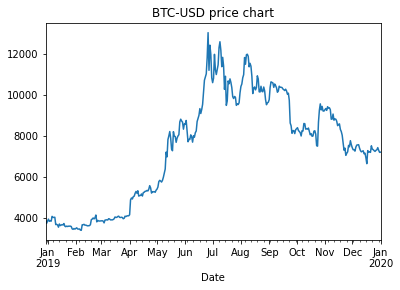

In [ ]:
data['Close'].plot(title="BTC-USD price chart")

In [ ]:
class TurtleStrategy(bt.Strategy):   
    params = ( ('maperiod', 15),  ('printlog', False), )   
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:            
            dt = dt or self.datas[0].datetime.date(0)           
            print('%s, %s' % (dt.isoformat(), txt))    

    def __init__(self):        

        self.dataclose = self.datas[0].close      
        self.datahigh = self.datas[0].high        
        self.datalow = self.datas[0].low     

        self.order = None      
        self.buyprice = 0      
        self.buycomm = 0      
        self.newstake = 0      
        self.buytime = 0       
        # calculate channel upper bond, channel lower bond and ATR       
        self.DonchianHi = bt.indicators.Highest(self.datahigh(-1), period=20, subplot=False)        
        self.DonchianLo = bt.indicators.Lowest(self.datalow(-1), period=10, subplot=False)       
        self.TR = bt.indicators.Max((self.datahigh(0)- self.datalow(0)), abs(self.dataclose(-1) -   self.datahigh(0)), abs(self.dataclose(-1)  - self.datalow(0) ))        
        self.ATR = bt.indicators.SimpleMovingAverage(self.TR, period=14, subplot=True)       
        # define cross over for upper bond and for lower bond      
        self.CrossoverHi = bt.ind.CrossOver(self.dataclose(0), self.DonchianHi)        
        self.CrossoverLo = bt.ind.CrossOver(self.dataclose(0), self.DonchianLo)    
    def notify_order(self, order):        
        if order.status in [order.Submitted, order.Accepted]:  return
        if order.status in [order.Completed]:            
            if order.isbuy():               
                self.log(                    
                'Buy at price: %.2f, Cost: %.2f' %                   
                (order.executed.price, order.executed.value,
                ),doprint=True)              
                self.buyprice = order.executed.price              
                self.buycomm = order.executed.comm            
            else:             
                     self.log('Sell at Price: %.2f, Cost: %.2f' %                        
                     (order.executed.price,
                     order.executed.value,
                     ),doprint=True)                             
                     self.bar_executed = len(self)       
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:           
            self.log('Order Failed')        
        self.order = None    

    def notify_trade(self, trade):      
        if not trade.isclosed:
            return        
        self.log('Trade P&L %.2f, Trade Net P&L %.2f' % (trade.pnl, trade.pnlcomm)) 

    def next(self): 
        if self.order:
            return        
        # buy if cross over upper bond         
        if self.CrossoverHi > 0 and self.buytime == 0:                                 
            self.newstake = self.broker.getvalue() * 0.01 / self.ATR            
            self.newstake = int(self.newstake / 100) * 100                             
            self.sizer.p.stake = self.newstake            
            self.buytime = 1            
            self.order = self.buy()        
        # buy more         
        elif self.datas[0].close >self.buyprice+0.5*self.ATR[0] and self.buytime > 0 and self.buytime < 5:           
            self.newstake = self.broker.getvalue() * 0.01 / self.ATR            
            self.newstake = int(self.newstake / 100) * 100            
            self.sizer.p.stake = self.newstake            
            self.order = self.buy()           
            self.buytime = self.buytime + 1        
        # sell if cross over lower bond         
        elif self.CrossoverLo < 0 and self.buytime > 0:            
            self.order = self.sell()            
            self.buytime = 0        
        # stop loss        
        elif self.datas[0].close < (self.buyprice - 2*self.ATR[0]) and self.buytime > 0:           
            self.order = self.sell()
            self.buytime = 0   
    def stop(self):        
        self.log('(MA Period %2d) Ending Value %.2f' % (self.params.maperiod, self.broker.getvalue()), doprint=True)

In [ ]:
# Postion control 
class TestSizer(bt.Sizer):
    params = (('stake', 1),)    
    def _getsizing(self, comminfo, cash, data, isbuy):        
        if isbuy:          
            return self.p.stake        
        position = self.broker.getposition(data)        
        if not position.size:            
            return 0        
        else:            
            return position.size        
        return self.p.stakeclass 

In [ ]:
# load different data
def load_stock_data(ticker_name, st, ed): 
    data = yf.Ticker(ticker_name).history(interval='1d', start=st,end=ed)
    columns=['Open','High','Low','Close','Volume']
    df = data[columns]
    return df
# load_stock_data('300274.SZ', '2018-12-30',ed='2020-01-02')
# data = load_stock_data('BTC-USD', '2018-12-30',ed='2022-05-02')
data = load_stock_data('SPY', '2018-12-30',ed='2022-05-02')

Starting Portfolio Value: 100000.00
2019-02-05, Buy at price: 254.89, Cost: 76466.24
2019-03-08, Sell at Price: 255.36, Cost: 76466.24
2019-03-22, Buy at price: 266.14, Cost: 79842.02
2019-05-08, Sell at Price: 270.19, Cost: 79842.02
2019-06-19, Buy at price: 274.91, Cost: 82472.24
2019-08-02, Sell at Price: 277.47, Cost: 82472.24
2019-09-06, Buy at price: 281.55, Cost: 56310.26
2019-10-02, Sell at Price: 276.52, Cost: 56310.26
2019-10-28, Buy at price: 287.38, Cost: 86212.91
2020-01-28, Sell at Price: 309.88, Cost: 86212.91
2020-02-07, Buy at price: 317.27, Cost: 95182.06
2020-02-25, Sell at Price: 308.81, Cost: 95182.06
2020-04-15, Buy at price: 266.16, Cost: 26616.03
2020-04-20, Buy at price: 270.99, Cost: 27099.31
2020-04-28, Buy at price: 279.06, Cost: 27905.74
2020-09-09, Sell at Price: 325.10, Cost: 81621.08
2020-10-09, Buy at price: 334.15, Cost: 66829.19
2020-10-27, Sell at Price: 328.54, Cost: 66829.19
2020-11-10, Buy at price: 341.81, Cost: 34181.40
2020-11-16, Buy at price:

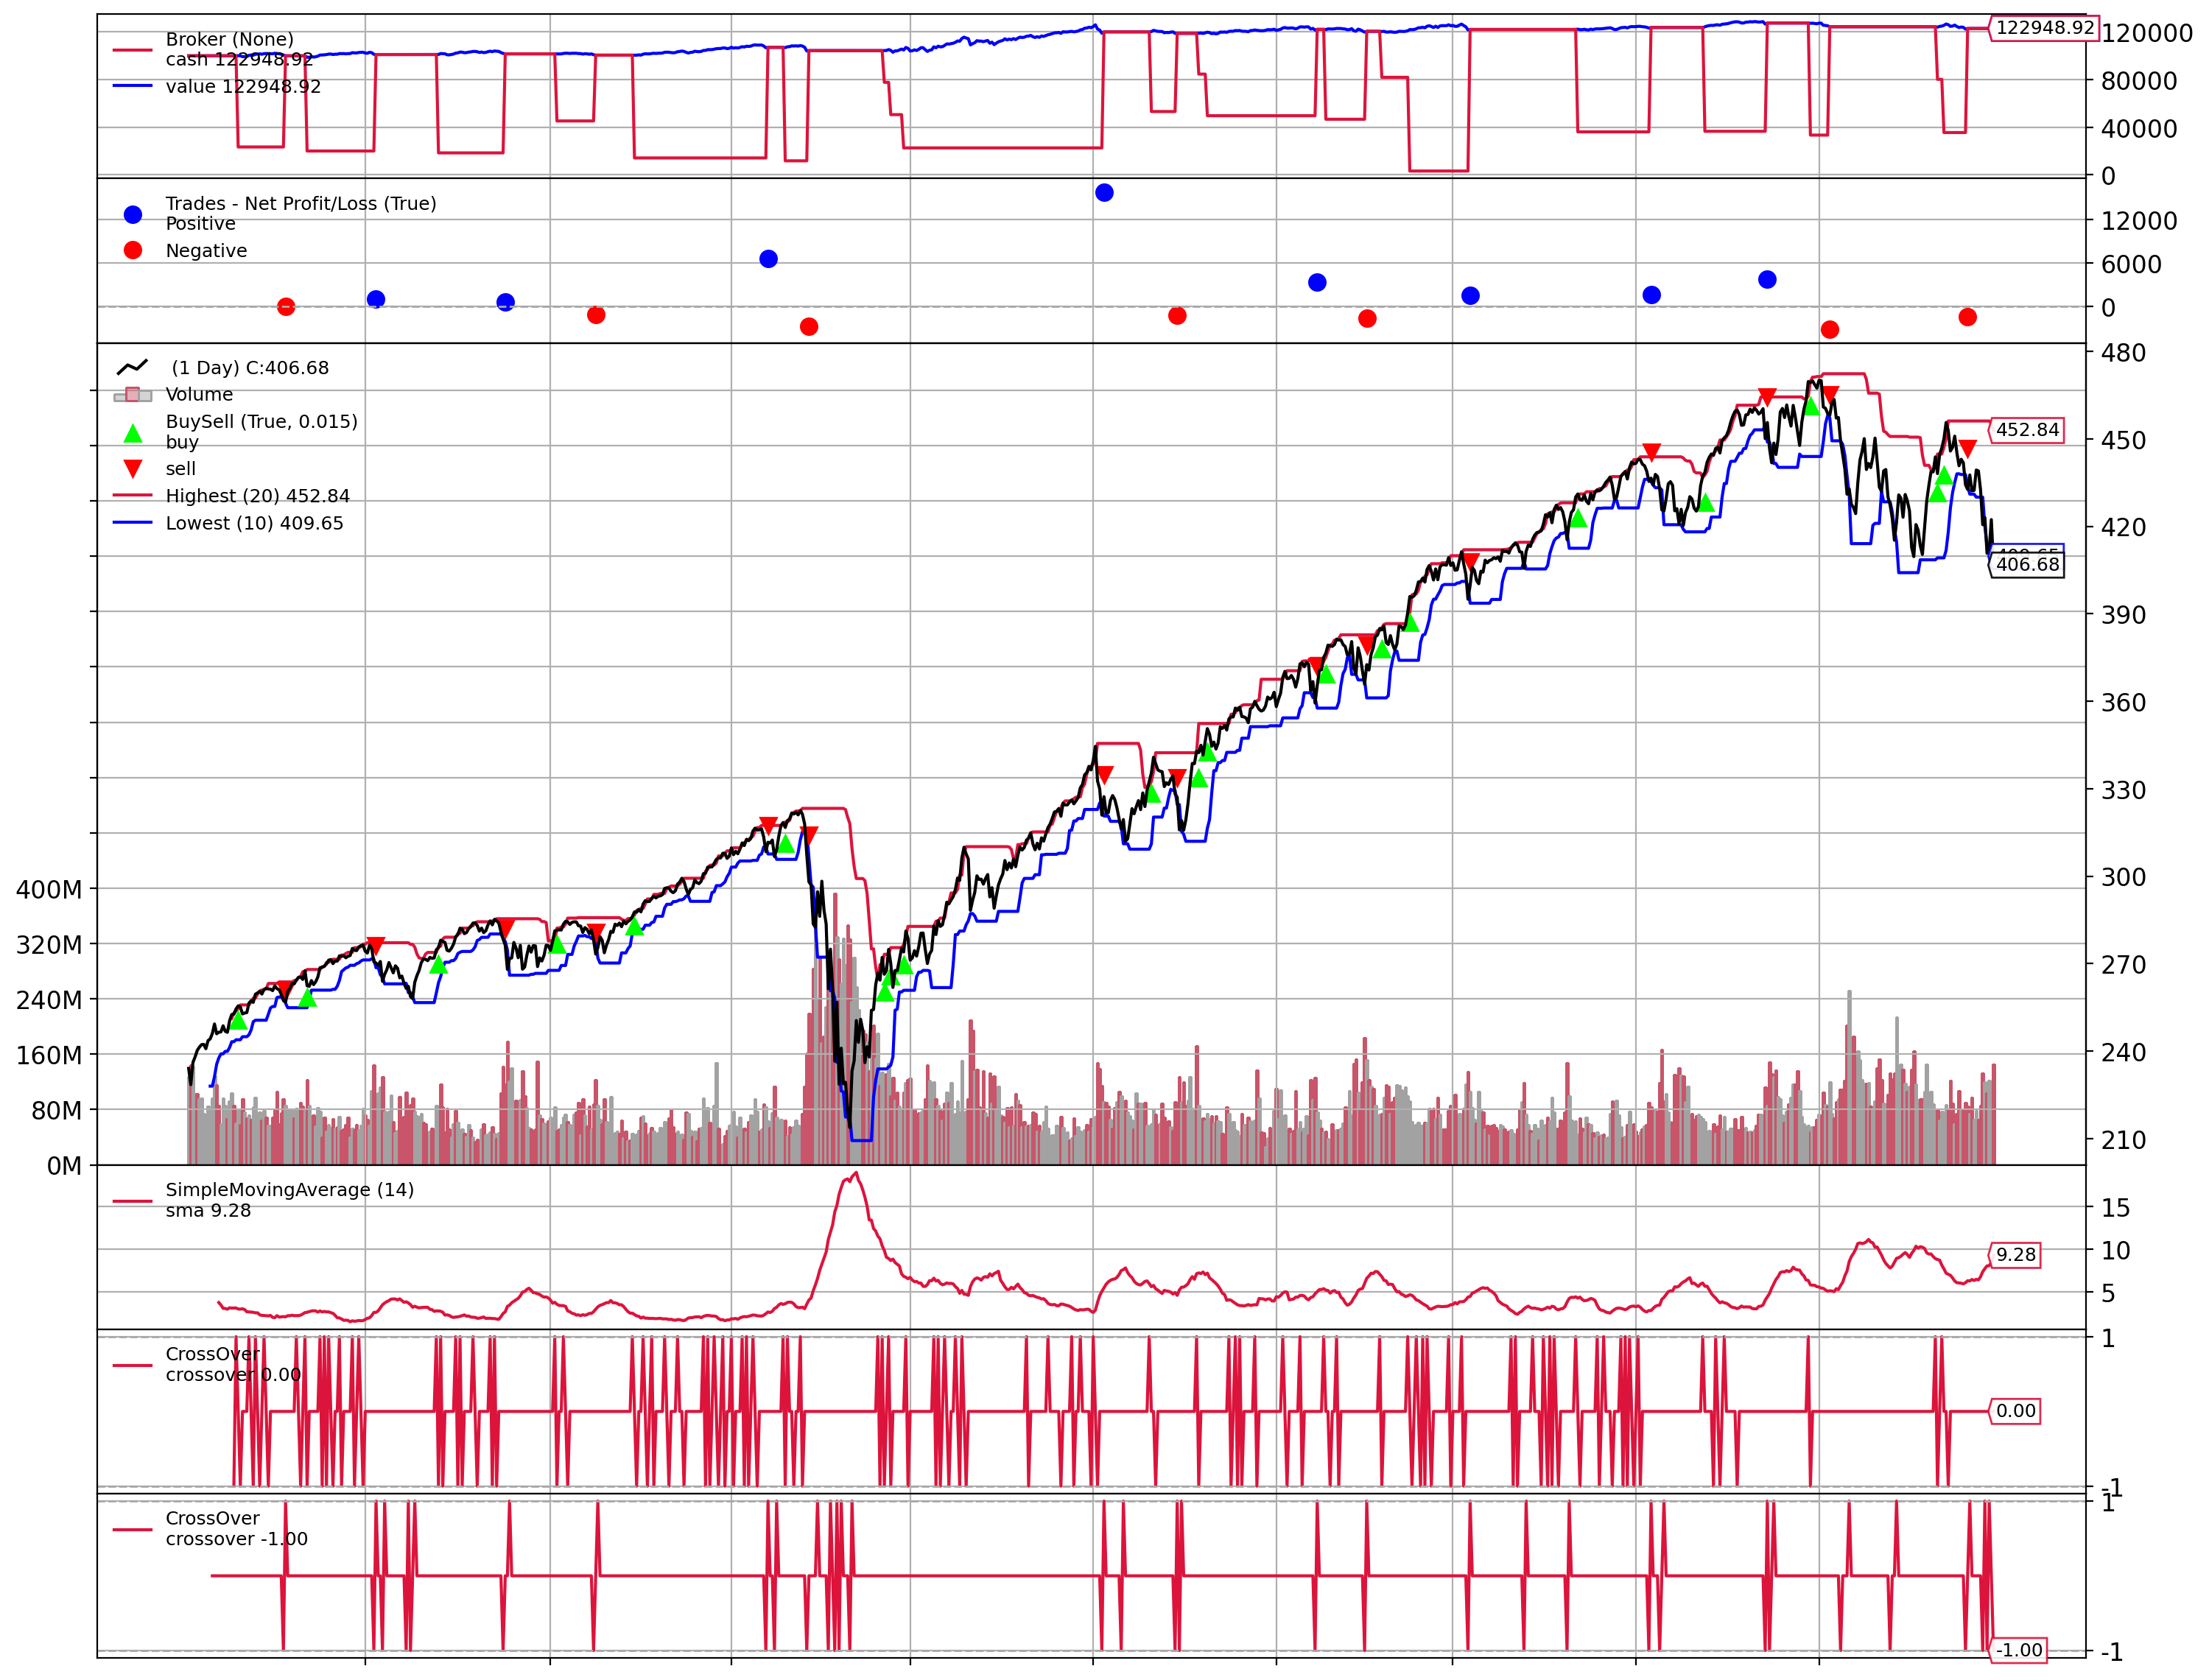

In [ ]:
fromdate=datetime.datetime(2019, 1, 1)
todate=datetime.datetime(2022, 5, 1)
def run_strategy(TestStrategy, df, fromdate, todate): 
    
    cerebro = bt.Cerebro()    
    # add strategy to Cerebro
    cerebro.addstrategy(TestStrategy)   
    # feed data into Cerebro 
    dataframe = df                           
    dataframe['openinterest'] = 0    
    data = bt.feeds.PandasData(dataname=dataframe,fromdate=fromdate,  todate=todate)    
    cerebro.adddata(data)    
    # set cash and commission for broker  
    cerebro.broker.setcash(100000.0)    
    cerebro.broker.setcommission(commission=0.001)
    # set buy size   
    cerebro.addsizer(TestSizer)    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())   
    # Start backtesting   
    cerebro.run()    
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())    
    # Curve backtesting result using cerebro.plot  
#     plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
#     plt.rcParams['figure.figsize']=[18, 16]
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams.update({'font.size': 12}) 
    plt.rcParams['figure.dpi']=200
    plt.rcParams['figure.facecolor']='w'
    plt.rcParams['figure.edgecolor']='k'
    cerebro.plot(iplot=False)

run_strategy(TurtleStrategy, data, fromdate, todate) 



Starting Portfolio Value: 100000.00
2020-02-07, BUY EXECUTED, Price: 317.27, Cost: 63454.71, Comm 63.45
2020-02-25, SELL EXECUTED, Price: 308.81, Cost: 63454.71, Comm 61.76
2020-04-20, BUY EXECUTED, Price: 270.99, Cost: 27099.31, Comm 27.10
2020-04-28, BUY EXECUTED, Price: 279.06, Cost: 27905.74, Comm 27.91
2020-05-19, BUY EXECUTED, Price: 282.25, Cost: 28225.06, Comm 28.23
2020-09-09, SELL EXECUTED, Price: 325.10, Cost: 83230.11, Comm 97.53
2020-10-09, BUY EXECUTED, Price: 334.15, Cost: 33414.59, Comm 33.41
2020-10-13, BUY EXECUTED, Price: 340.64, Cost: 34064.40, Comm 34.06
2020-10-27, SELL EXECUTED, Price: 328.54, Cost: 67478.99, Comm 65.71
2020-11-10, BUY EXECUTED, Price: 341.81, Cost: 34181.40, Comm 34.18
2020-11-16, BUY EXECUTED, Price: 349.06, Cost: 34905.65, Comm 34.91
2021-02-01, SELL EXECUTED, Price: 362.92, Cost: 69087.05, Comm 72.58
2021-02-05, BUY EXECUTED, Price: 376.98, Cost: 75395.52, Comm 75.40
2021-03-05, SELL EXECUTED, Price: 369.46, Cost: 75395.52, Comm 73.89
2021-03

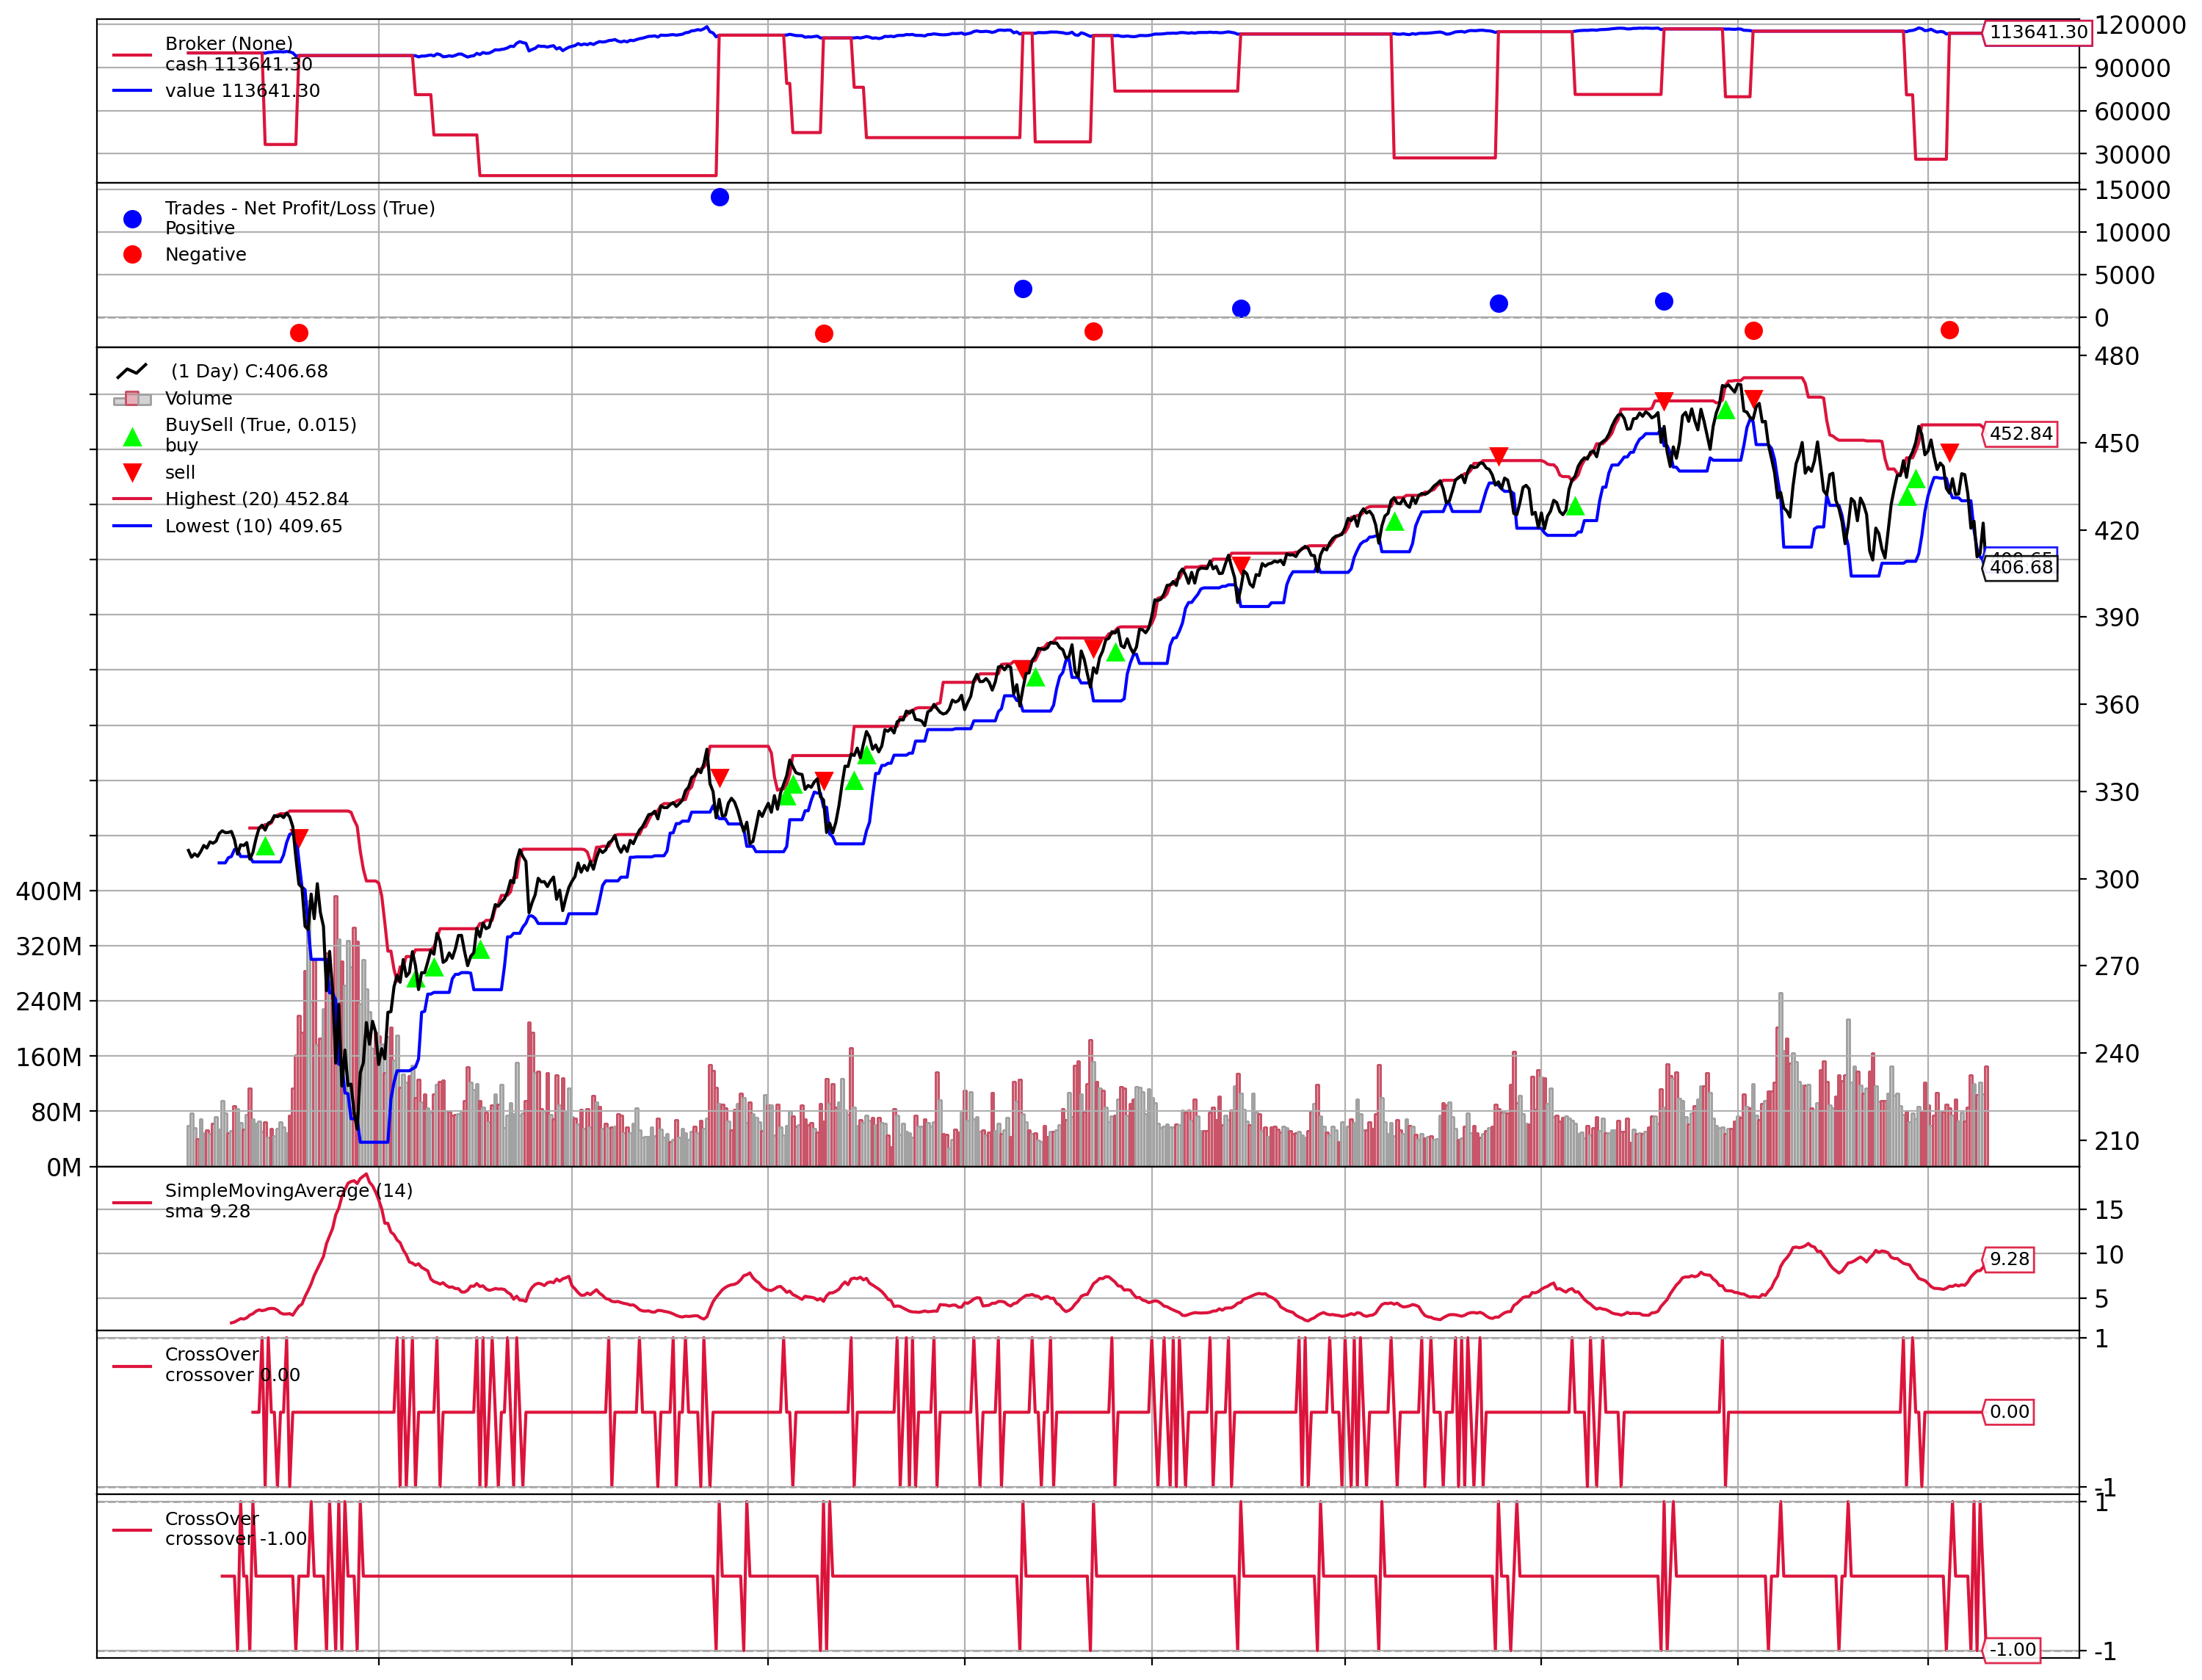

In [ ]:
run_strategy(TestStrategy, data, fromdate, todate) 
    